# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Initialize simulator

In [3]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 3
ROUNDS = 3
OTHER_DATE = '2023-10-27'
_RESETS = False
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


# Get IQ data

In [4]:
SHOTS = int(1e4)
NOISE_LIST = [3e-2, 0.8e-2, 1e-2, 3e-2] # [two-qubit-fidelity, reset error, measurement error, idle error]
# NOISE_LIST = None

IQ_data= simulator.generate_IQ(SHOTS, noise_list=NOISE_LIST)

100%|██████████| 255/255 [00:00<00:00, 6204.38it/s]


# Simulator

# Decode IQ data

In [5]:
import pymatching
import stim

model = simulator.stim_circ.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

In [6]:
import numpy as np
from src import cpp_soft_info
from Scratch import load_calibration_memory

absError = -1
relError = 1

linspace = [0.5, 0.7, 21]
bandwiths = np.linspace(linspace[0], linspace[1], linspace[2])
all_memories = load_calibration_memory(provider, tobecalib_backend=DEVICE, other_date=OTHER_DATE)
kde_dict = cpp_soft_info.get_KDEs(all_memories, bandwiths, relError=relError, absError=absError, num_points=51)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.


# Info perfo tradeoff

In [9]:
from tqdm import tqdm

_DETAILED = False

num_errors = []
bits = list(range(20))
for nb_bits in tqdm(bits[1:]):
    result_kde = cpp_soft_info.decode_IQ_kde(model, IQ_data, ROUNDS, int(LOGICAL), _RESETS, 
                                         simulator.qubit_mapping, kde_dict, _DETAILED, relError=relError, absError=absError,
                                         nb_intervals=2**nb_bits)
    num_errors.append(result_kde.num_errors)
    

100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


In [10]:
print(num_errors)

[437, 430, 412, 405, 424, 425, 418, 413, 413, 415, 414, 414, 413, 413, 412, 412, 412, 412, 412]


In [11]:
import json

metadata = {"DEVICE": DEVICE, "DISTANCE": DISTANCE, "ROUNDS": ROUNDS, "OTHER_DATE": OTHER_DATE, "_RESETS": _RESETS, "LOGICAL": LOGICAL, "SHOTS": SHOTS, "NOISE_LIST": NOISE_LIST, "bandwiths_linspace": linspace, "relError": relError}


with open(f"result_tradeoff_plot.json", "r") as f:
    data = json.load(f)
    data_in_str = [str(d) for d in data]
    if str({"metadata": metadata, "num_errors": num_errors}) not in data_in_str:
        data.append({"metadata": metadata, "num_errors": num_errors, "bits": bits[1:]})

with open(f"result_tradeoff_plot.json", "w") as f:
    json.dump(data, f, indent=1)

# Plot the data from the json

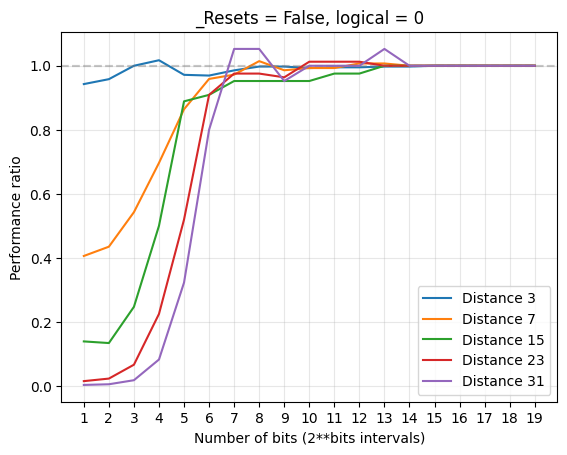

In [63]:
import matplotlib.pyplot as plt 

with open(f"result_tradeoff_plot.json", "r") as f:
    data = json.load(f)

for result in data:
    if result["metadata"]["DISTANCE"] != result["metadata"]["ROUNDS"]:
        continue
    
    errors = [result["num_errors"][-1]/e for e in result["num_errors"][:-1]]
    bits = [2**b for b in result["bits"][:-1]]
    bits = result["bits"][:-1]
    plt.plot(bits[:], errors[:], label=f"Distance {result['metadata']['DISTANCE']}")
    plt.title(f"_Resets = {result['metadata']['_RESETS']}, logical = {result['metadata']['LOGICAL']}")
    plt.xlabel("Number of bits (2**bits intervals)")
    plt.ylabel("Performance ratio")
    plt.xticks(bits)
    plt.axhline(y=1, color='grey', linestyle='--', alpha=0.1)
    plt.legend()
    plt.grid(alpha=0.3)


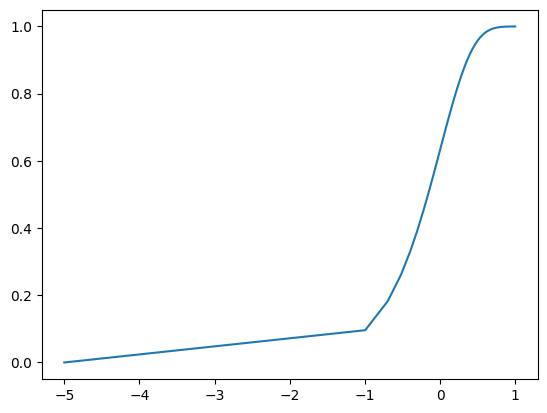

In [52]:
plt.plot(np.log10(np.linspace(1e-5,10,100)),1-np.exp(-np.linspace(0,10,100)))

In [ ]:
def run(distance, resets):
    simulator = RepCodeIQSimulator(provider, distance, distance, DEVICE, _is_hex=_is_hex, _resets = resets, other_date=OTHER_DATE)
    SHOTS = int(1e5)
    NOISE_LIST = [3e-2, 0.8e-2, 1e-2, 3e-2] # [two-qubit-fidelity, reset error, measurement error, idle error]
    # NOISE_LIST = None

    IQ_data= simulator.generate_IQ(SHOTS, noise_list=NOISE_LIST)
    
    

# Using cpp kde

In [ ]:
_DETAILED = False



matching = pymatching.Matching.from_detector_error_model(model)
result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                            p_offset = 1, p_multiplicator = 1, _ntnn_edges = not _RESETS)


print("num_errors IQ:", result.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)

In [ ]:
relError = -1
absError = -1

relError = 1
# absError = 10

result_kde = cpp_soft_info.decode_IQ_kde(model, IQ_data, ROUNDS, int(LOGICAL), _RESETS, 
                                         simulator.qubit_mapping, kde_dict, _DETAILED, relError=relError, absError=absError,
                                         nb_intervals=-1)

print("num_errors KDE:", result_kde.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)


In [ ]:
p_meas = -1
# p_meas = 7e-2 

matching = pymatching.Matching.from_detector_error_model(model)
result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, IQ_data[:],
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=_DETAILED, _ntnn_edges = True)

print("num_errors informed:", result_informed.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
# takes 1s

In [ ]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=_DETAILED)


print("num_errors:", result_flat.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)

# Plot the results

In [ ]:
print("\nIQ:", result.indices, "\nkde:", sorted(result_kde.indices), "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)

In [ ]:
from soft_info import draw_matching_graph


index = 6196

fig_size = (4, 13)
fig_size = (8, 8)
scale_factor = 0.5

to_be_result = result_kde
details = to_be_result.error_details[index]
print(f"----- First {bool(not (index in to_be_result.indices))} decoding -----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result
details = to_be_result.error_details[index]
print(f"-----Second {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
print(f"-----Third {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [ ]:
informed_not_in_iq = sorted(set(result_informed.indices) - set(result.indices))
print("indices that are in informed but not in IQ with len:", len(informed_not_in_iq))
print(informed_not_in_iq)
iq_not_in_informed = sorted(set(result.indices) - set(result_informed.indices))
print("indices that are in IQ but not in informed with len:", len(iq_not_in_informed))
print(iq_not_in_informed)

print()

iq_not_in_flat = sorted(set(result.indices) - set(result_flat.indices))
print("indices that are in IQ but not in flat with len:", len(iq_not_in_flat))
print(iq_not_in_flat)
flat_not_in_iq = sorted(set(result_flat.indices) - set(result.indices))
print("indices that are in flat but not in IQ with len:", len(flat_not_in_iq))
print(flat_not_in_iq)

print()

iq_not_in_kde = sorted(set(result.indices) - set(result_kde.indices))
print("indices that are in IQ but not in kde with len:", len(iq_not_in_kde))
print(iq_not_in_kde)
kde_not_in_iq = sorted(set(result_kde.indices) - set(result.indices))
print("indices that are in kde but not in IQ with len:", len(kde_not_in_iq))
print(kde_not_in_iq)